# MDS HW1 資管碩一 R10725026 黃奕滔
## Config.

In [122]:
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
# from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import seaborn as sns 

sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

In [14]:
def plot(df, y):
    xs = [x for x in df.columns if x != y]
    plt.figure(figsize=(12, 8))
    for i, x in enumerate(xs):
        plt.subplot((len(xs)+1)//2, 2, i+1)
        plt.scatter(df[x], df[y])
        plt.xlabel(x)
        plt.ylabel(y)
    plt.show()
def check_norm(resid):
    plt.hist(resid, bins = 'auto')
    plt.show()
    
    sm.qqplot(resid, stats.norm, fit=True, line='45')
    plt.show()
    
    stat, p = stats.shapiro(resid)
    print(f'Shapiro: statistics={stat:.3f}, p={p:.3f}')
def check_heter(result):
    _, stat, names = sso.summary_table(res, alpha=0.05)
    plt.scatter(stat[:,2], res.resid)
    plt.axhline(y=0, color = 'red')
    plt.xlabel('prediction')
    plt.ylabel('residuals')



def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

def detect_outlier(data_1):
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    outliers = []
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

## 1. 
### Read Files

In [6]:
furnace_data = pd.read_csv("MDS_Assignment1_furnace.csv")
display(furnace_data)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f19,f20,f21,f22,f23,f24,f25,f26,f27,grade
0,1.848564,-0.264250,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,0.443257,-0.406121,-0.687687,0.271886,3.727218,0.102129,2
1,-0.825098,-0.264250,3.032397,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-0.232546,-0.406366,-0.687687,0.271886,-0.232472,0.102129,4
2,1.848564,-0.264250,-0.461423,0.409400,1.305455,2.329398,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,1.459782,1.221876,1.877777,0.271886,-0.232472,0.102129,2
3,0.511733,-0.264250,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,-0.008030,-0.406366,1.504523,0.271886,-0.232472,0.102129,2
4,-0.825098,-0.264250,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,0.925358,-0.573268,-1.164793,1.877777,0.271886,-0.232472,0.102129,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,-0.825098,-0.264250,2.004803,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-0.684962,-0.406121,-0.687687,0.271886,-0.232472,0.102129,2
616,-0.379487,3.809407,-0.461423,0.409400,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,2.248407,-0.332678,-0.687687,0.271886,4.519156,0.102129,2
617,-0.825098,-0.264250,-0.461423,0.409400,-0.525726,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,-1.023427,1.332042,-0.687687,0.271886,-0.232472,0.102129,2
618,-0.825098,-0.264250,2.004803,-2.442599,1.305455,-0.276144,0.370965,0.090167,0.107958,0.0,...,0.085505,0.233285,-1.080663,3.150982,-1.777067,-0.687687,0.271886,-0.232472,0.102129,2


## Regression

In [10]:
furnace_X = furnace_data.iloc[:, :-1]
furnace_y = furnace_data.iloc[:, -1]
furnace_X_const = sm.add_constant(furnace_X)
furnace_X_const = furnace_X_const.rename(columns={"const": "Intercept"})
# display(furnace_X_const)
# display(furnace_y)

In [11]:
furnace_model = sm.OLS(furnace_y, furnace_X_const)
furnace_result = furnace_model.fit()
print(furnace_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     21.52
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           1.16e-70
Time:                        01:01:35   Log-Likelihood:                -381.52
No. Observations:                 620   AIC:                             819.0
Df Residuals:                     592   BIC:                             943.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0339      0.018    110.528      0.0

### Residual Analysis
https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-regression/simple-linear-regression-assumptions.html
#### Normality check
$H_0$ : the residual is normal  
$H_1$ : the residual is not normal

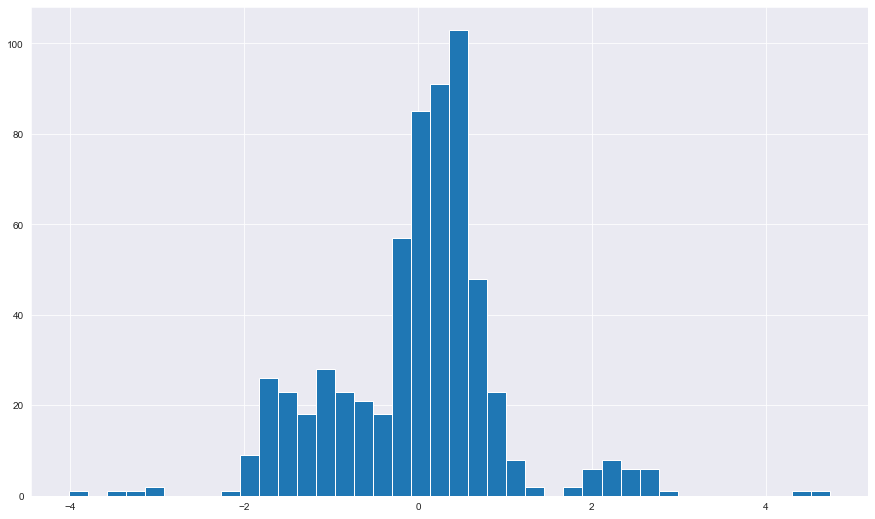

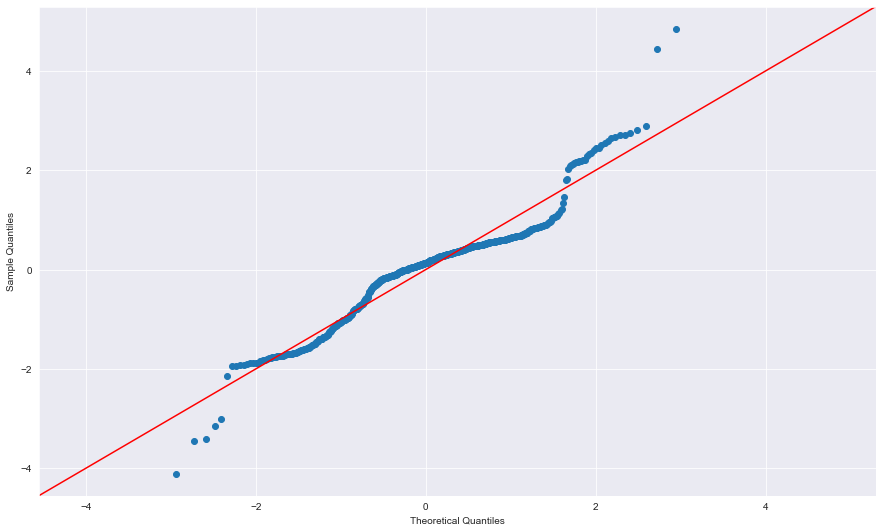

Shapiro: statistics=0.935, p=0.000


In [12]:
check_norm(furnace_result.resid_pearson)

The residual is not normal.
  
#### Check Homoscedasticity assumption
$H_0:$ Homoscedasticity  
$H_1:$ Hetroscedasticity

/Users/cupid/Desktop/projects/MDS_hw/env/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:696: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)



 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  1.406203e+02
p-value                        5.871843e-17
f-value                        6.431711e+00
f p-value                      5.311816e-20

 Goldfeld-Quandt test ----
                value
F statistic  1.024212
p-value      0.420429

 Residuals plots ----


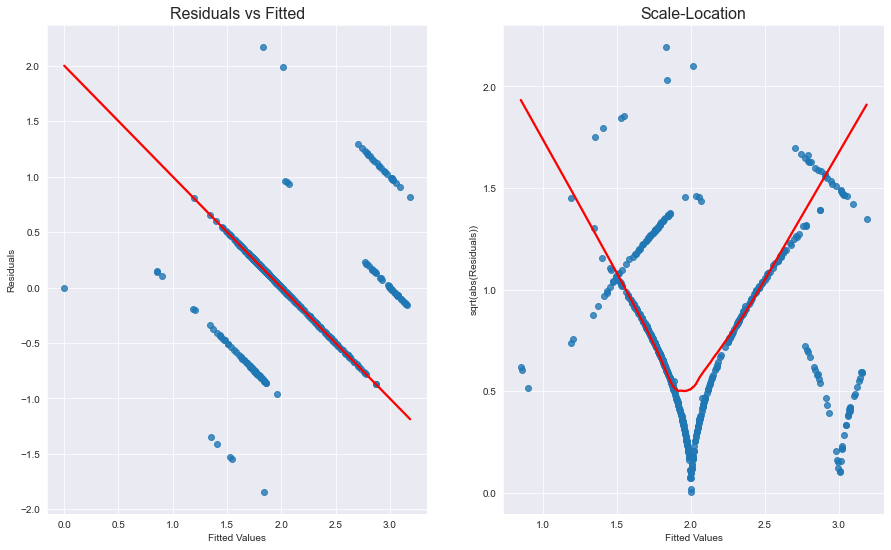

In [15]:
homoscedasticity_test(furnace_result)

BP test shows hetroscedasticity, GQ test shows homoscedasticity.
#### Independent assumption

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(furnace_X_const.values, i) for i in range(furnace_X_const.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=furnace_X.columns).T


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27
vif,1.81784,2.314364,3.571219,5.095433,4.30931,2.623037,1.983188,2.24362,1.054478,NaN,...,1.266249,2.060656,1.12521,2.356358,1.319547,1.162346,1.7176,1.17451,1.449481,1.085164


None of the VIF value of the features > 5, therefore, no significant multicolinearity within the variables.

In [20]:
furnace_pvalues = furnace_result.pvalues
print(furnace_pvalues.sort_values())




Intercept    0.000000e+00
f18          6.355895e-19
f2           2.430368e-18
f14          6.896905e-18
f15          3.971326e-08
f22          4.429125e-04
f17          6.967770e-04
f25          7.041639e-04
f6           6.295708e-03
f5           1.331207e-02
f8           3.036614e-02
f10          3.450386e-02
f16          7.959189e-02
f26          1.046465e-01
f1           1.167404e-01
f11          1.509174e-01
f13          1.585856e-01
f9           1.863555e-01
f21          2.071131e-01
f19          2.938197e-01
f7           3.938391e-01
f24          4.237986e-01
f20          5.200766e-01
f3           6.547220e-01
f23          6.586476e-01
f27          7.464190e-01
f0           8.231798e-01
f4           9.275234e-01
f12          9.785198e-01
dtype: float64


In [21]:
for i in range(len(furnace_pvalues.sort_values())):
    if furnace_pvalues.sort_values()[i] < 0.01:
        print(furnace_pvalues.sort_values().index[i])


Intercept
f18
f2
f14
f15
f22
f17
f25
f6


## 2.
### Read file

In [115]:
census_data = pd.read_csv("./MDS_Assignment1_census.csv", header=None)
census_data = census_data.replace({" ?": np.nan, "?": np.nan})
census_colname = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", 
                  "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "class"]
census_data.columns = census_colname
census_data = census_data.astype({"age": "float64", "fnlwgt": "float64", "education-num": "float64", "capital-gain": "float64", 
                                  "capital-loss": "float64", "hours-per-week": "float64"})
display(census_data)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [116]:
census_des = census_data.describe()
census_des = census_des.append(census_data.isna().sum().rename("na_cnt"))

In [117]:
outlier_cnt = []
for col in census_data.columns:
    if census_data[col].dtype == np.float64:
        # print(type(census_data.iloc[:, col][0]))
        outlier_cnt.append(len(detect_outlier(census_data[col])))
    else:
        outlier_cnt.append(np.nan)
outlier_cnt = pd.Series(outlier_cnt, name='outlier_cnt', index=census_des.columns)
census_des = census_des.append(outlier_cnt)

In [118]:
census_des

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class,education,marital-status,native-country,occupation,race,relationship,sex,workclass
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
na_cnt,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,583.0,1843.0,0.0,0.0,0.0,1836.0
outlier_cnt,121.000000,NaN,347.000000,NaN,219.000000,NaN,NaN,NaN,NaN,NaN,215.0,1470.0,440.0,NaN,NaN


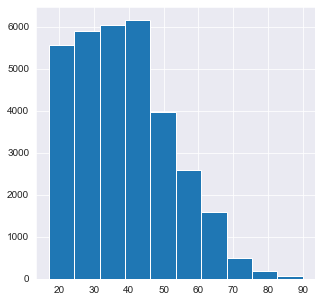

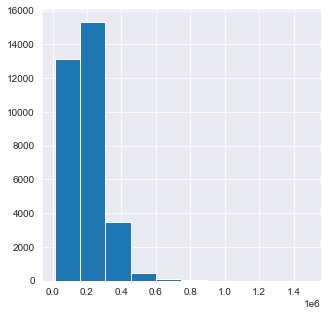

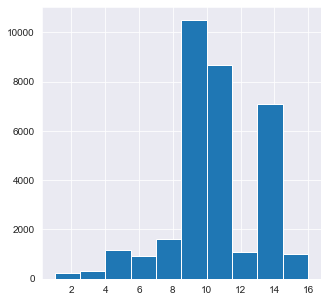

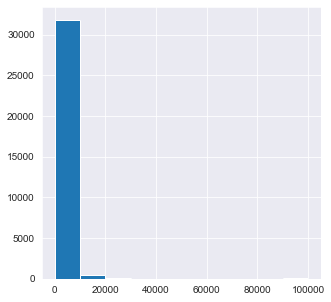

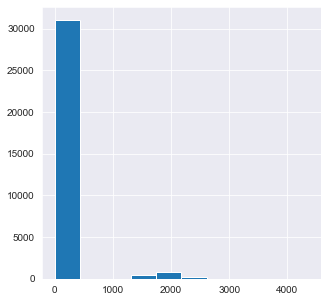

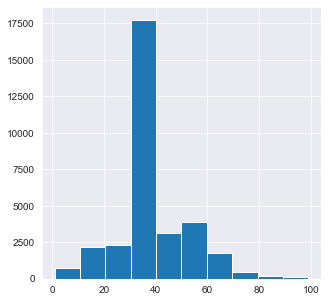

In [166]:
for i in range(census_data.shape[1]):
    if(type(census_data.iloc[:, i][0]) == np.float64):
        plt.figure(i, figsize=(5, 5))
        plt.hist(census_data.iloc[:, i])
        pass

In [119]:
imputer = SimpleImputer(strategy='most_frequent')
# imputer = KNNImputer()
imputer.fit(census_data)
imputed_census = imputer.transform(census_data)

In [120]:
imputed_census = pd.DataFrame(imputed_census)
imputed_census.columns = census_colname
pd.options.display.max_columns = None
pd.options.display.max_rows = 40
imputed_census

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
32557,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
32558,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
32559,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [20]:
# imputed_kidney = imputed_kidney.replace({" yes": "yes"})
# imputed_kidney["diabetes_mellitus"].unique()
# for col in imputed_kidney:
#     print(imputed_kidney[col].unique())

array(['yes', 'no'], dtype=object)

In [121]:
census_dummies = pd.get_dummies(data=imputed_census, 
columns=["workclass", "education", "marital-status", "occupation", 
"relationship", "race", "sex", "native-country", "class"], drop_first=True)
census_dummies

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,class_ >50K
0,39.0,77516.0,13.0,2174.0,0.0,40.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,257302.0,12.0,0.0,0.0,38.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
32557,40.0,154374.0,9.0,

In [123]:
census_X = census_dummies.drop(columns=["class_ >50K"])
census_y = census_dummies["class_ >50K"]

census_X_train, census_X_test, census_y_train, census_y_test = train_test_split(census_X, census_y, test_size=0.20, random_state=42)

In [124]:
from sklearn.linear_model import LogisticRegression
census_lr = LogisticRegression().fit(census_X_train, census_y_train)

/Users/cupid/Desktop/projects/MDS_hw/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [125]:
print("Mean accuracy of self.predict(X) wrt. y:", census_lr.score(census_X_test, census_y_test))

Mean accuracy of self.predict(X) wrt. y: 0.7821280515891295


In [129]:
census_data["class"].value_counts()
7841 / 24720

0.31719255663430423

## 3. 
### Read File

In [130]:
groceries_data = pd.read_csv("MDS_Assignment1_groceries.csv", header=None, sep='\n')
groceries_data = groceries_data.values.tolist()
trans = []
for ele in groceries_data:
    trans.append(ele[0].split(","))


In [131]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(trans).transform(trans)
trans_bool = pd.DataFrame(te_ary, columns=te.columns_)
trans_bool

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,

In [132]:
from mlxtend.frequent_patterns import apriori
asso = apriori(trans_bool, min_support=0.001, use_colnames=True)
# asso

In [133]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(asso, metric="lift", min_threshold=-1)
rules[rules['confidence'] >= 0.15]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(Instant food products),(butter),0.008033,0.055414,0.001220,0.151899,2.741145,0.000775,1.113765
6,(Instant food products),(curd),0.008033,0.053279,0.001322,0.164557,3.088583,0.000894,1.133196
12,(Instant food products),(hamburger meat),0.008033,0.033249,0.003050,0.379747,11.421438,0.002783,1.558640
17,(Instant food products),(other vegetables),0.008033,0.193493,0.002745,0.341772,1.766332,0.001191,1.225271
18,(Instant food products),(pastry),0.008033,0.088968,0.001423,0.177215,1.991899,0.000709,1.107254
...,...,...,...,...,...,...,...,...,...
102723,"(tropical fruit, whipped/sour cream, whole mil...","(other vegetables, yogurt)",0.002745,0.043416,0.001118,0.407407,9.383728,0.000999,1.614235
102724,"(tropical fruit, whole milk, root vegetables, ...","(other vegetables, whipped/sour cream)",0.005694,0.028876,0.001118,0.196429,6.802377,0.000954,1.208509
102736,"(whipped/sour cream, root vegetables, yogurt)","(other vegetables, tropical fruit, whole milk)",0.006406,0.017082,0.001118,0.174603,10.221561,0.001009,1.190843
102737,"(tropical fruit, whipped/sour cream, yogurt)","(other vegetables, whole milk, root vegetables)",0.006202,0.023183,0.001118,0.180328,7.778617,0.000975,1.191717


In [168]:
rules = rules[rules['confidence'] >= 0.15].sort_values(by='confidence', ascending=False)
rules[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
44790,"(rice, sugar)",(whole milk),0.001220,0.255516,0.001220,1.0,3.913649,0.000908,inf
93000,"(tropical fruit, fruit/vegetable juice, whippe...",(other vegetables),0.001017,0.193493,0.001017,1.0,5.168156,0.000820,inf
98790,"(rolls/buns, soda, newspapers, whole milk)",(other vegetables),0.001017,0.193493,0.001017,1.0,5.168156,0.000820,inf
55141,"(pip fruit, brown bread, whipped/sour cream)",(other vegetables),0.001118,0.193493,0.001118,1.0,5.168156,0.000902,inf
91768,"(other vegetables, pip fruit, bottled water, r...",(whole milk),0.001118,0.255516,0.001118,1.0,3.913649,0.000833,inf


In [162]:
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()

  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show): 
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')
  ed = G1.edges()
#   print(edges)
  colors = [G1[u][v]['color'] for u,v in ed]
  weights = [G1[u][v]['weight'] for u,v in ed]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

<AxesSubplot:title={'center':'Association Rules'}, xlabel='support', ylabel='confidence'>

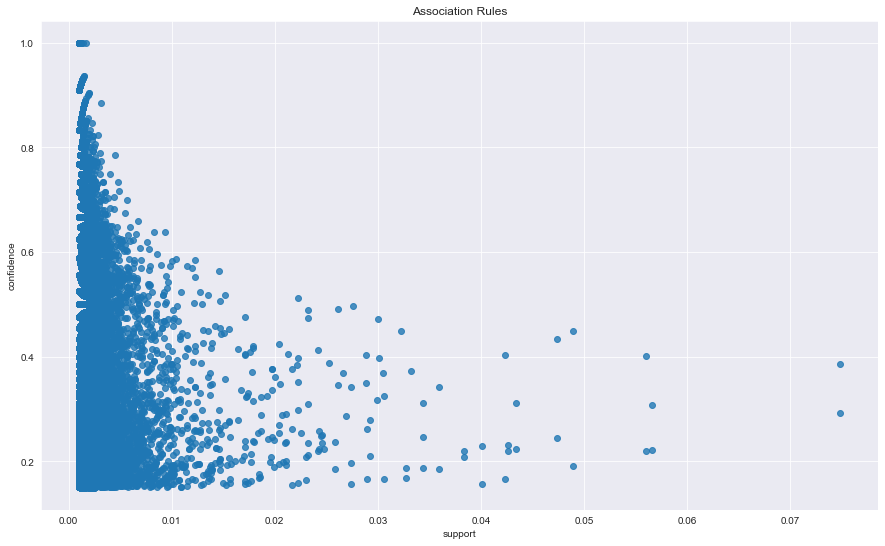

In [163]:
support=rules['support']
confidence=rules['confidence']
 
import seaborn as sns1
 
# for i in range (len(support)):
#     support[i] = support[i] 
#     confidence[i] = confidence[i] 
     
plt.title('Association Rules')
plt.xlabel('support')
plt.ylabel('confidence')    
sns1.regplot(x=support, y=confidence, fit_reg=False)

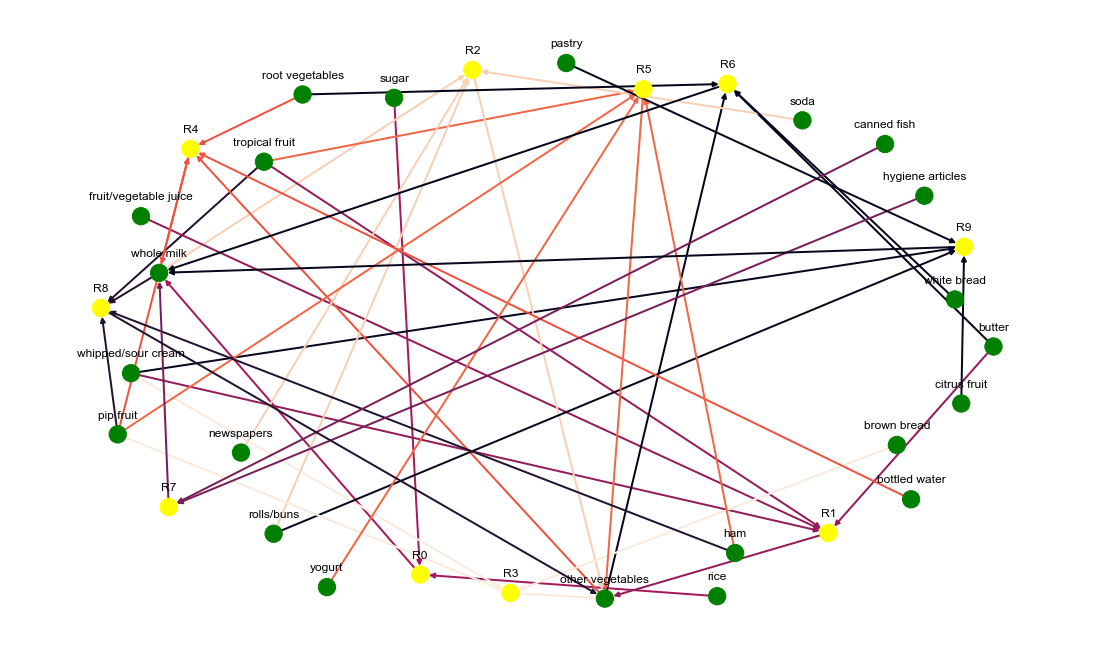

In [169]:
draw_graph(rules, 10)

In [146]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
44790,"(rice, sugar)",(whole milk),0.001220,0.255516,0.001220,1.00,3.913649,0.000908,inf
73423,"(root vegetables, whipped/sour cream, flour)",(whole milk),0.001729,0.255516,0.001729,1.00,3.913649,0.001287,inf
57142,"(butter, domestic eggs, soft cheese)",(whole milk),0.001017,0.255516,0.001017,1.00,3.913649,0.000757,inf
93236,"(other vegetables, whipped/sour cream, pork, b...",(whole milk),0.001017,0.255516,0.001017,1.00,3.913649,0.000757,inf
95486,"(rolls/buns, citrus fruit, pastry, whipped/sou...",(whole milk),0.001017,0.255516,0.001017,1.00,3.913649,0.000757,inf
...,...,...,...,...,...,...,...,...,...
101647,"(soda, whole milk, root vegetables)","(pip fruit, yogurt)",0.008134,0.017997,0.001220,0.15,8.334746,0.001074,1.155298
7048,"(soda, beef)",(brown bread),0.008134,0.064870,0.001220,0.15,2.312304,0.000692,1.100153
86018,(turkey),"(other vegetables, whole milk, root vegetables)",0.008134,0.023183,0.001220,0.15,6.470395,0.001032,1.149197
55728,"(tropical fruit, root vegetables, yogurt)",(brown bread),0.008134,0.064870,0.001220,0.15,2.312304,0.000692,1.100153
